In [1]:
#here we rerun the genotype calling including a) the depth channels which required a more supervised approach b) the ATACseq channels.
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
library(GenotypeMixtures)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
#get the sequencing inventory and make a multiplexing matrix  - write out the relevant files ####
tenx_dir <- "./data/seq_data/10X_3p"
sequencing_inventory <- read.csv("/nfs/team297/bs16/sample_donor_data/sequencing_inventory.csv", check.names = FALSE)
sequencing_inventory <- sequencing_inventory[
    sequencing_inventory$experiment %in% c("10X_ATACseq", "10X_multiome_ATAC") & 
                                           sequencing_inventory$cellranger_SOC %in% 'TRUE' & 
                                             sequencing_inventory$poor_QC %in% "FALSE",]
#exclude fetal - these are one per channel and we will analyse these elsewhere
sequencing_inventory <- sequencing_inventory[!sequencing_inventory$tissue %in% grep("fetal", sequencing_inventory$tissue, value = TRUE), ]
#fix the irods spaces
sequencing_inventory$irods_ID <- gsub(" ", "", sequencing_inventory$irods_ID)
table(sequencing_inventory$tissue)
#copy
multiplex_design = sequencing_inventory


kidney_single_nucleus_suspension 
                              24 

In [3]:
#get channels
channels <- multiplex_design$sanger_ID
#get the correct directory 
seq_dir = multiplex_design$`10xDIR`
#reset some of the directory names names
seq_dir[seq_dir == '10x3p'] = '10X_3p'
seq_dir[seq_dir == '10xATAC'] = '10X_snATACseq'
seq_dir[seq_dir == '10x_multiome'] = '10X_multiome'
#then build a multiplexing matrix
channel_donors <- strsplit(multiplex_design$donor, "_")
names(channel_donors) <- multiplex_design$sanger_ID
donors <- unique(unlist(channel_donors))
multiplexing_mat <- do.call(rbind, lapply(names(channel_donors), function(i){
  donors %in% channel_donors[[i]]*1
}))
colnames(multiplexing_mat) <- donors
rownames(multiplexing_mat) <- names(channel_donors)

In [4]:
#we treat k250/k251 as the same because of how this design is a bit awkward.
multiplexing_mat = cbind(multiplexing_mat, "K250_K251" =  multiplexing_mat[, "K250"] + multiplexing_mat[, "K251"])
multiplexing_mat[multiplexing_mat == 2] = 1
multiplexing_mat = multiplexing_mat[, !colnames(multiplexing_mat) %in% c("K250", "K251")]

In [5]:
#get the locations of the files ####
dirs <- multiplex_design[match(multiplex_design$sanger_ID, rownames(multiplexing_mat)), "10xDIR"]
locations <- data.frame("channel" = rownames(multiplexing_mat), 
                        "SOC_location" = file.path("/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/seq_data", seq_dir, multiplex_design$irods_ID, "SOC_common_variants"))

Using channel as id variables



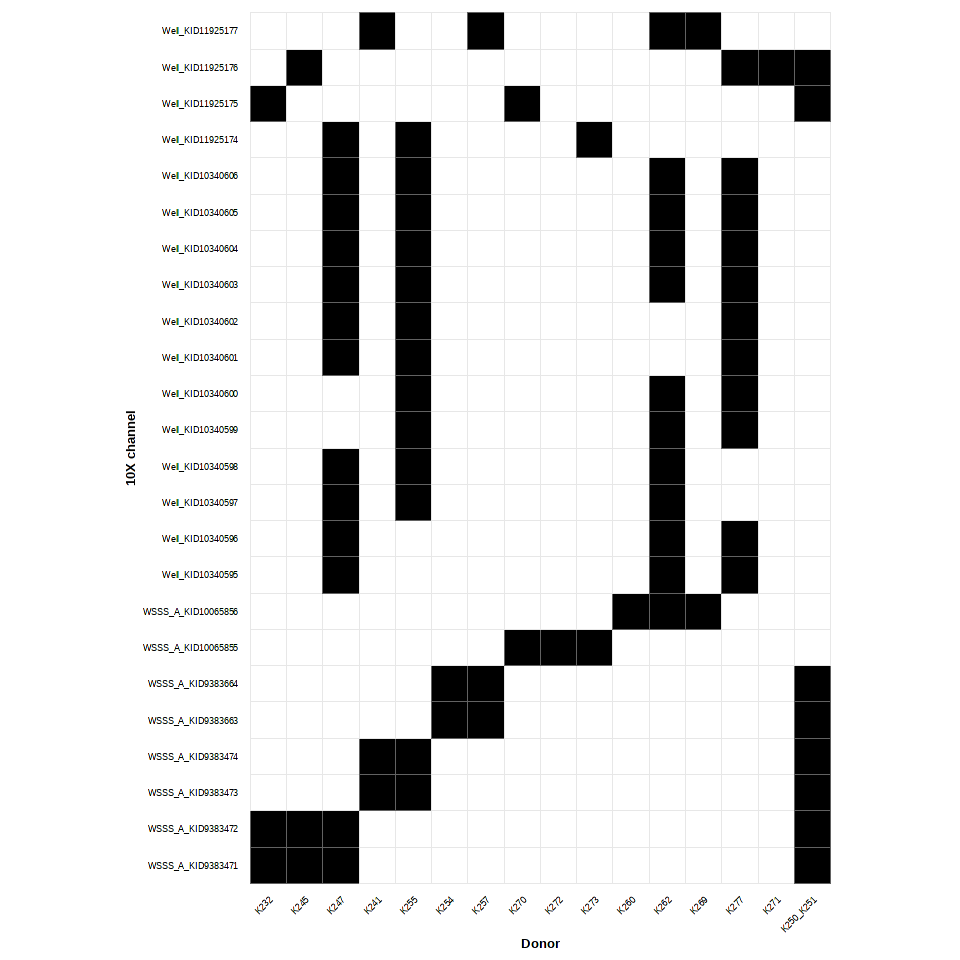

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_experimental_design(multiplexing_mat)

In [9]:
genotype_clustering_output <- construct_genotype_cluster_graph_unsupervised(locations, ncounts  = 10, use_VAF = TRUE)

reading in VCF files


   *****       ***   vcfR   ***       *****
   This is vcfR 1.13.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


the membership graph is a collection of complete subgraphs as expected



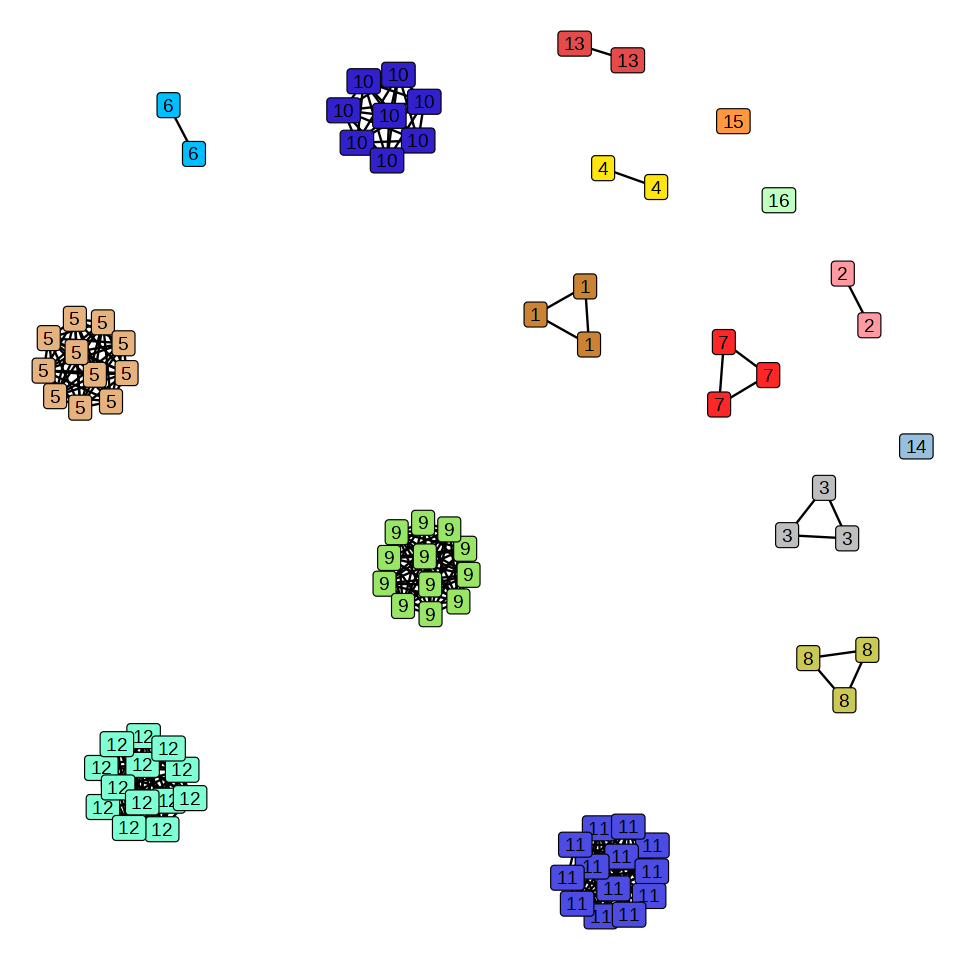

In [10]:
genotype_clustering_output$graph_plot

In [11]:
#write read the clustering                                                               
saveRDS(genotype_clustering_output, "data/genotypes/genotype_clustering_output_nuclei.RDS")
genotype_clustering_output <- readRDS("data/genotypes/genotype_clustering_output_nuclei.RDS")

In [12]:
#map clusters to samples ####
cluster_mapping <- membership_map(experimental_design = multiplexing_mat,
                                  graph_output =  genotype_clustering_output)
cluster_mapping$sample <- sequencing_inventory[match(cluster_mapping$channel, sequencing_inventory$sanger_ID), "irods_ID"]

In [16]:
multiplexing_mat <- do.call(rbind, lapply(names(channel_donors), function(i){
  donors %in% channel_donors[[i]]*1
}))
colnames(multiplexing_mat) <- donors
rownames(multiplexing_mat) <- names(channel_donors)

In [23]:
table(cluster_mapping$genotype)


     K232      K241      K245      K247 K250_K251      K254      K255      K257 
        3         3         3        13         8         2        13         3 
     K260      K262      K269      K270      K271      K272      K273      K277 
        1        12         2         2         1         1         2        11 

In [24]:
#sort out K250, K251
for(i in c("K250", "K251")){
    ch = rownames(multiplexing_mat)[multiplexing_mat[, i] > 0]
  cluster_mapping[cluster_mapping$channel %in% ch & 
                 cluster_mapping$genotype %in% "K250_K251", "genotype"]  = i 
}
table(cluster_mapping$genotype)


K232 K241 K245 K247 K250 K251 K254 K255 K257 K260 K262 K269 K270 K271 K272 K273 
   3    3    3   13    3    5    2   13    3    1   12    2    2    1    1    2 
K277 
  11 

In [25]:
saveRDS(cluster_mapping, "data/genotypes/cluster_mapping_nuclei.RDS")

In [34]:
cell_assignments <- cells_to_genotypes(SOC_locations = locations, 
                                       membership_mat =cluster_mapping)
saveRDS(cell_assignments, "data/genotypes/cell_assignments_nuclei.RDS")

In [27]:
write.csv(cell_assignments,
          "data/genotypes/cell_assignments_nuclei.csv", 
         row.names = FALSE)

In [28]:
#get ambients
ambient <- suppressWarnings(unlist(lapply(locations$SOC_location, function(x){
  amb <- read.table(file.path(x, 'ambient_rna.txt'), check.names = FALSE)
  amb <- amb[, 5]
  amb <- as.numeric(gsub("%", "", amb))/100
  return(amb)})))
names(ambient) <- locations$channel
saveRDS(ambient, "data/genotypes/ambient_proportions_nuclei.RDS")

In [29]:
ambient

WSSS_A_KID9383471  WSSS_A_KID9383472  WSSS_A_KID9383473  WSSS_A_KID9383474 
        0.12106960         0.11811532         0.09285080         0.10537222 
 WSSS_A_KID9383663  WSSS_A_KID9383664 WSSS_A_KID10065855 WSSS_A_KID10065856 
        0.10561901         0.08037692         0.18512324         0.22642027 
  Well_KID10340595   Well_KID10340596   Well_KID10340597   Well_KID10340598 
        0.02583862         0.03757807         0.03656990         0.03923358 
  Well_KID10340599   Well_KID10340600   Well_KID10340601   Well_KID10340602 
        0.04869329         0.06089424         0.08004266         0.08270384 
  Well_KID10340603   Well_KID10340604   Well_KID10340605   Well_KID10340606 
        0.04479058         0.07015835         0.03571213         0.05503669 
  Well_KID11925174   Well_KID11925175   Well_KID11925176   Well_KID11925177 
        0.08497226         0.08636987         0.03863662         0.04084146

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


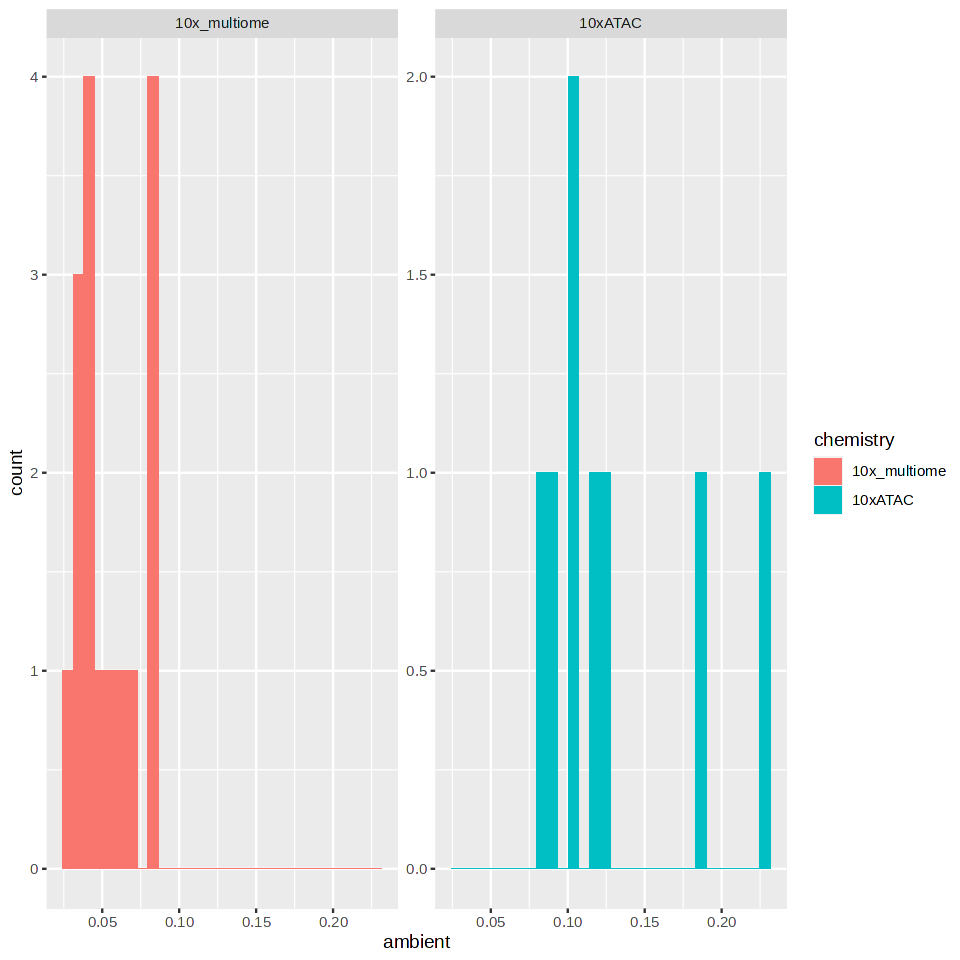

In [30]:
ggplot(data.frame('ambient' = ambient, "chemistry" = sequencing_inventory$'10xDIR'), aes(x=ambient)) + 
geom_histogram(aes(fill = chemistry)) + facet_wrap(~chemistry, scales = 'free_y')

In [31]:
table(cell_assignments$genotype[cell_assignments$status == 'singlet'])


 K232  K241  K245  K247  K250  K251  K254  K255  K257  K260  K262  K269  K270 
 4285 10101  3841 16252  5088 10825  1994 25369  3750  1158 22796  2795  2662 
 K271  K272  K273  K277 
 2447  2675  4301 30044 